# Example for saving data to netcdf

Some specific commands for Jupyter:

In [1]:
# Jupyter Notebook with widget matplotlib plots
#%matplotlib notebook
# Jupyter Lab with widget matplotlib plots
#%matplotlib widget 
# with Jupyter and Jupyter Lab but without widget matplotlib plots
%matplotlib inline
%load_ext autoreload
%autoreload 2

Load necessary modules:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import sys
import pyicon as pyic
import xarray as xr
import cartopy.crs as ccrs

calc
tb
IconData
plotting
view
calc
tb
IconData
plotting
view
quickplots
quickplots


## Names and paths

Define the name of the simulation, its grid, the path to the data and paths to the grid:

In [3]:
run = 'nib0004'
runname = 'icon_08'
gname = 'r2b6_oce_r0004'
lev = 'L64'

path_data     = f'/mnt/lustre01/work/mh0033/m300602/proj_vmix/icon/{runname}/icon-oes/experiments/{run}/'
path_grid     = f'/mnt/lustre01/work/mh0033/m300602/icon/grids/{gname}/'
path_ckdtree  = f'{path_grid}ckdtree/'
fpath_fx      = f'{path_grid}{gname}_{lev}_fx.nc'
fpath_ckdtree = f'{path_grid}ckdtree/rectgrids/{gname}_res0.30_180W-180E_90S-90N.npz'

## Pyicon IconData object

Create a pyicon IconData object. This object contains information about the grid, and the time steps which are in the given data directory.

In [4]:
IcD = pyic.IconData(
    fname        = run+'_????????????????.nc',
    path_data    = path_data,
    path_grid    = path_grid,
    gname        = gname,
    lev          = lev,
    #do_only_timesteps = True,
    load_vertical_grid     = True,
    load_rectangular_grid  = True,
    do_triangulation       = False,
    load_triangular_grid   = False,
    calc_coeff             = False,
)

## Load and interpolate the data

In [5]:
IcD.times.min(), IcD.times.max()

(numpy.datetime64('2001-01-01T00:00:00'),
 numpy.datetime64('2301-01-01T00:00:00'))

Load the data:

In [6]:
to, it_ave = pyic.time_average(IcD, 'to', t1='2210-02-01', t2='2212-01-01')
to.shape

(64, 235403)

(Optional) Infer time mean of averaging interval:

In [7]:
if len(it_ave)==1:
    time_ave = IcD.times[it_ave[0]]
else:
    time_ave = IcD.times[it_ave[0]] + 0.5*(IcD.times[it_ave[-1]]-IcD.times[it_ave[0]])
time_ave

numpy.datetime64('2211-07-02T12:00:00')

In [8]:
time_ave

numpy.datetime64('2211-07-02T12:00:00')

(Optional) Infer time bounds of averaging interval:

In [9]:
time_bnds = [IcD.times[it_ave[0]], IcD.times[it_ave[-1]]]

Interpolate to rectangular grid:

In [10]:
lon, lat, toi = pyic.interp_to_rectgrid(to, fpath_ckdtree)
toi.shape

(64, 600, 1200)

## Use xarray to save the data

This is probably the most flexible and therefore preferred way. However, some basic knwoledge about xarray is necessary to get the full flexibility.

Create xarray dataset:

In [11]:
ds = xr.Dataset(coords={'depthc': IcD.depthc, 'lat': lat, 'lon': lon, 'icell': np.arange(to.shape[1])})
ds['toi'] = xr.DataArray(toi, dims=['depthc', 'lat', 'lon'])
ds['to'] = xr.DataArray(to, dims=['depthc', 'icell'])

(Optional) Add full names and units:

In [12]:
ds['lon'].attrs = dict(long_name='longitude')
ds['lat'].attrs = dict(long_name='latitude')
ds['depthc'].attrs = dict(long_name='depth', units='m')

ds['toi'].attrs = dict(long_name='temperature on rectangular grid', units='degC')
ds['to'].attrs = dict(long_name='temperature on original grid', units='degC')

(Optional) Add time dimension:

In [13]:
ds = ds.expand_dims(time=[time_ave])
ds['time_bnds'] = xr.DataArray(time_bnds)

In [14]:
ds

<xarray.Dataset>
Dimensions:    (depthc: 64, dim_0: 2, icell: 235403, lat: 600, lon: 1200, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2211-07-02T12:00:00
  * depthc     (depthc) float64 6.0 17.0 27.0 ... 5.088e+03 5.334e+03 5.589e+03
  * icell      (icell) int64 0 1 2 3 4 5 ... 235398 235399 235400 235401 235402
  * lat        (lat) float64 -90.0 -89.7 -89.4 -89.1 ... 88.8 89.1 89.4 89.7
  * lon        (lon) float64 -180.0 -179.7 -179.4 -179.1 ... 179.1 179.4 179.7
Dimensions without coordinates: dim_0
Data variables:
    toi        (time, depthc, lat, lon) float32 nan nan nan nan ... nan nan nan
    to         (time, depthc, icell) float32 0.0 -1.7998707 0.0 ... 0.0 0.0 0.0
    time_bnds  (dim_0) datetime64[ns] 2211-01-01 2212-01-01

Save xarray dataset to netcdf file:

In [15]:
fpath_nc = '/scratch/m/m300602/tmp/test_pyicon_output/test.nc'
ds.to_netcdf(fpath_nc)

## Using pyic.write_dataarray_to_nc to save the data

You can save a single data array with the following pyicon function (however, the function is just a simple wrapper aroung xarray and xarray could also used directly):

In [16]:
ds = pyic.write_dataarray_to_nc('/scratch/m/m300602/tmp/test_pyicon_output/test.nc',
                                toi, name='to_interpolated', coords={'depth': IcD.depthc, 'lat': lat, 'lon': lon},
                                long_name='temperature', units='units',              # optional
                                long_name_coords=['depth', 'latitude', 'longitude'], # optional
                                units_coords=['m', 'degrees North', 'degrees West'], # optional
                                time_bnds=time_bnds,                                 # optional
                               )

Writing data file /scratch/m/m300602/tmp/test_pyicon_output/test.nc.


## Use pyic.hplot_base or pyic.vplot_base to save the data

If `pyic.hplot_base` or `pyic.vplot_base` is used, there is an option of directly storing the data which is plotted. This option is intended to facilitated documentation for papers:

To use `pyic.hplot_base` you need to specify an IconVariable first:

In [17]:
IaV = pyic.IconVariable('to', units='deg C', long_name='temperature')
IaV.data = toi[0,:]

Make a plot and simply add `save_data=True` and `fpath_nc=...` and the data will be saved.

Writing data file /scratch/m/m300602/tmp/test_pyicon_output/test2.nc.


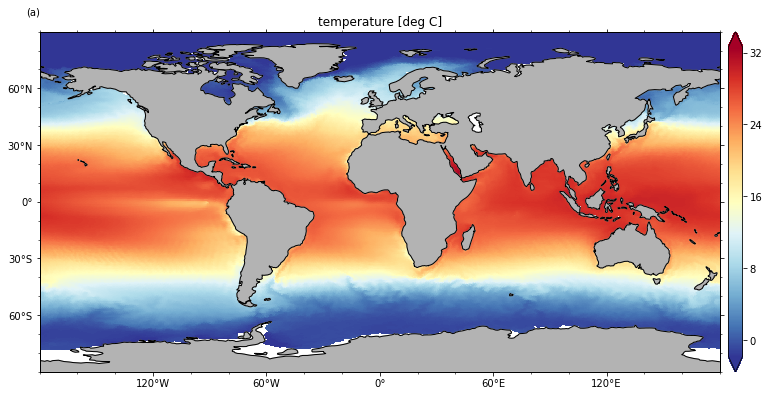

In [18]:
hca, hcb = pyic.arrange_axes(1,1, projection=ccrs.PlateCarree(), asp=0.5, fig_size_fac=3.) # optional

ax, cax, mappable, Dstr = pyic.hplot_base(IcD, IaV, 
                                          clim='auto', cmap='RdYlBu_r',     # optional
                                          xlim=[-180,180], ylim=[-90,90],   # optional
                                          do_plot_settings=True,            # optional
                                          ax=hca[0], cax=hcb[0],            # optional
                                          save_data=True, 
                                          fpath_nc='/scratch/m/m300602/tmp/test_pyicon_output/test2.nc',
                                         )